In [17]:
import xarray as xr 
import glob 
import matplotlib.pyplot as plt
from scipy.signal import detrend

import numpy as np
import copy
import os 
import sys 
import matplotlib.pyplot as plt 
import glob
import pickle

import cartopy.crs as ccrs

from sklearn.preprocessing import QuantileTransformer
from functools import lru_cache

import math
import copy
from pathlib import Path
from random import random
from functools import partial
from collections import namedtuple
from multiprocessing import cpu_count

from scipy.optimize import linear_sum_assignment
from PIL import Image
from tqdm.auto import tqdm

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.colors as mcolors

from eofs.xarray import Eof

import torch
from typing import Dict
from credit.physics_constants import RAD_EARTH, GRAVITY
from credit.physics_constants import RAD_EARTH, GRAVITY

import glob

from torch import nn
import numpy as np
import os

from credit.data import get_forward_data
from credit.transforms import load_transforms
from credit.physics_core import physics_pressure_level, physics_hybrid_sigma_level
from credit.physics_constants import (
    GRAVITY,
    RHO_WATER,
    LH_WATER,
    CP_DRY,
    CP_VAPOR,
)
from credit.postblock import GlobalEnergyFixer

import logging
import yaml
from credit.parser import credit_main_parser, predict_data_check


## Total Water Column

In [4]:
print('...grab the model runs....')
FNS = sorted(glob.glob('/glade/derecho/scratch/wchapman/CREDIT/cesm_wxformer_00191_nb/model_00223_b/1979-01-01T00Z/1D/averaged_UVTQtotPSPRECTTREFHT*'))
print('... opening model run ...')
DSs = xr.open_mfdataset(FNS)

...grab the model runs....
... opening model run ...


## Open Files and Compute Path

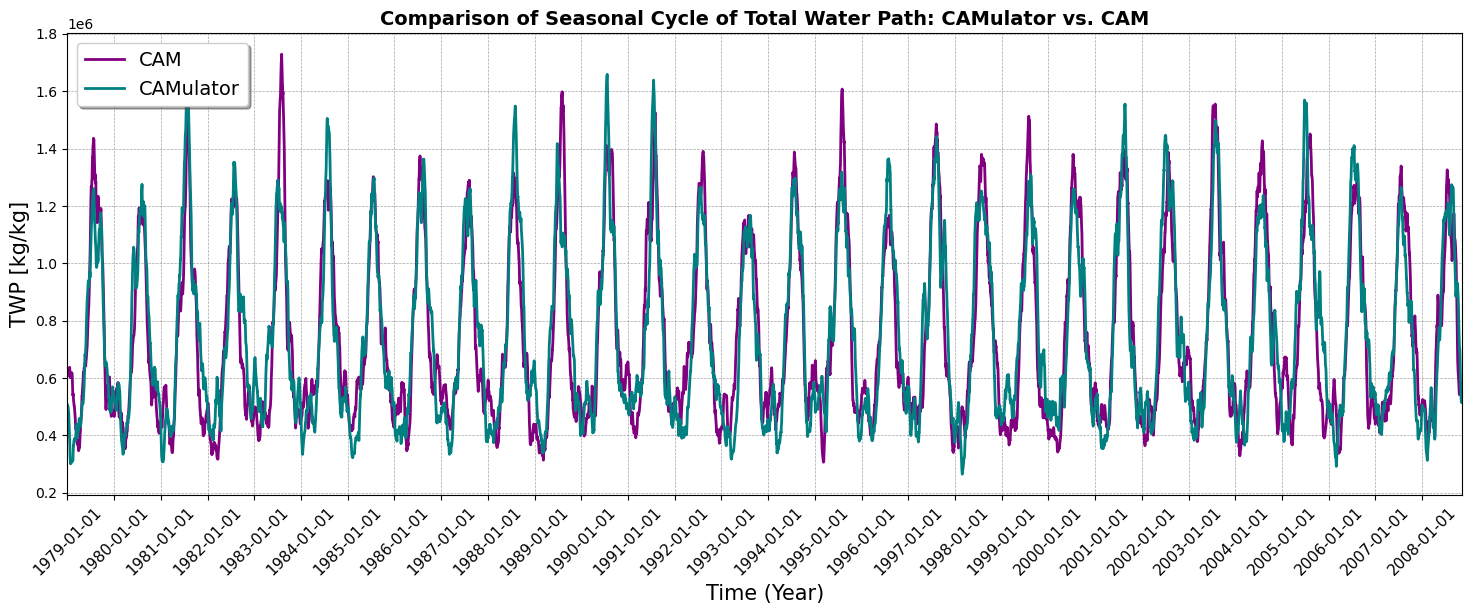

In [47]:
model_level_file = '/glade/campaign/cisl/aiml/wchapman/MLWPS/STAGING/f.e21.CREDIT_climate.statics_1.0deg_32levs_latlon_F32_hyai.nc'
DSml = xr.open_dataset(model_level_file)
DSml

phsl = physics_hybrid_sigma_level(lat=torch.tensor(DSml['lat2d'].values), 
                           lon = torch.tensor(DSml['lat2d'].values),
                           coef_a = torch.tensor(DSml['hyai'].values),
                           coef_b = torch.tensor(DSml['hybi'].values),midpoint=True)
bb = phsl.total_column_water(torch.tensor(np.expand_dims(DSs['Qtot'].isel(time=0).values,[0])),torch.tensor(np.expand_dims(DSs['PS'].isel(time=0).values,[0])))

tottote = []
for dd in range(10950):
    if (dd%2000) == 0:
        print(f'loop number {dd}')
    bb = phsl.total_column_water(torch.tensor(np.expand_dims(DSs['Qtot'].isel(time=dd).values,[0])),torch.tensor(np.expand_dims(DSs['PS'].isel(time=dd).values,[0])))
    Col_tot = phsl.weighted_sum(bb, axis=(-2, -1))
    tottote.append(np.array(Col_tot)[0])
# plt.plot(tottote)
# plt.show()

conc = []
for yryr in range(1979,2009):
    print(f'doing {yryr}')
    DSdo_1 = xr.open_zarr(f'/glade/campaign/cisl/aiml/wchapman/MLWPS/STAGING/f.e21.CREDIT_climate_{yryr}_ERA5scaled_F32_Qtot.zarr')
    conc.append(DSdo_1)

print('... resampling and loading ....')
DSzarr1 = xr.concat(conc, dim='time')
DSzarr1_TP = DSzarr1[['PS','Qtot']].resample(time='1D').mean().load()
print('... resampled and loaded ....')

DSzarr1_TP
tottot = []
for dd in range(10950):
    if (dd%2000) == 0:
        print(f'loop number {dd}')
    bb = phsl.total_column_water(torch.tensor(np.expand_dims(DSzarr1_TP['Qtot'].isel(time=dd).values,[0])),torch.tensor(np.expand_dims(DSzarr1_TP['PS'].isel(time=dd).values,[0])))
    Col_tot = phsl.weighted_sum(bb, axis=(-2, -1))
    tottot.append(np.array(Col_tot)[0])
# plt.plot(tottot)


def smooth_1d_array(data, window_size):
    """
    Apply a moving average smoothing filter to a 1D numpy array.

    Parameters:
    -----------
    data : np.ndarray
        The 1D array to smooth.
    window_size : int
        The size of the moving window (number of time steps).

    Returns:
    --------
    np.ndarray
        The smoothed array, with the same length as the input array.
    """
    if window_size < 1:
        raise ValueError("Window size must be at least 1.")
    if len(data) < window_size:
        raise ValueError("Data length must be greater than or equal to the window size.")

    # Pad the array to handle edge effects
    padded_data = np.pad(data, pad_width=(window_size // 2,), mode='reflect')

    # Apply convolution for smoothing
    smoothed_data = np.convolve(padded_data, np.ones(window_size) / window_size, mode='valid')

    return smoothed_data


# Create the plot
plt.figure(figsize=(18, 6))  # Larger figure for better visibility

# Convert cftime to datetime
time_converted = [t.strftime('%Y-%m-%d') for t in DSzarr1_TP['time'].values]

# Extract indices for January 1 of each year
year_ticks = [i for i, t in enumerate(DSzarr1_TP['time'].values) if t.month == 1 and t.day == 1]

plt.plot(time_converted[:],smooth_1d_array(tottot,30)[:-1], label = 'CAM',color='purple', linewidth=2)
plt.plot(time_converted[:],smooth_1d_array(tottote,30)[:-1], label = 'CAMulator',color='teal', linewidth=2)
plt.legend()

# Customize x-axis ticks to show years
plt.xticks(
    year_ticks,
    [time_converted[i] for i in year_ticks],
    rotation=45,
    fontsize=11  # Smaller font size for clarity
)
# Adjust x-axis limits and labels
# plt.xlim([0, 5110])  # Limit the x-axis range
plt.xlabel("Time (Year)", fontsize=15)
plt.ylabel("TWP [kg/kg]", fontsize=15)
plt.xlim([0, 10900])  # Limit the x-axis range

# Add legend with improved styling
plt.legend(
    loc='upper left',
    fontsize=14,
    frameon=True,
    fancybox=True,
    shadow=True
)
# Add a title
plt.title("Comparison of Seasonal Cycle of Total Water Path: CAMulator vs. CAM", fontsize=14, fontweight='bold')

# Add grid lines for better readability
plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)

plt.show()

## Total System Energy

- get timestep-to-timestep

- Need to make this figure from the input shit. 

In [3]:
print('...grab the model runs....')
FNS = sorted(glob.glob('/glade/derecho/scratch/wchapman/CREDIT/cesm_wxformer_00191_nb/model_00223_b/1979-01-01T00Z/pred_*'))
print('... opening model run ...')
from dask.distributed import Client
client = Client()
DSs = xr.open_mfdataset(FNS[:300]).load()

...grab the model runs....
... opening model run ...


In [5]:
model_level_file = '/glade/campaign/cisl/aiml/wchapman/MLWPS/STAGING/f.e21.CREDIT_climate.statics_1.0deg_32levs_latlon_F32_hyai.nc'
DSml = xr.open_dataset(model_level_file)
DSml
a=
phsl = physics_hybrid_sigma_level(lat=torch.tensor(DSml['lat2d'].values), 
                           lon = torch.tensor(DSml['lat2d'].values),
                           coef_a = torch.tensor(DSml['hyai'].values),
                           coef_b = torch.tensor(DSml['hybi'].values), midpoint=True)

In [146]:
config = '/glade/derecho/scratch/wchapman/CREDIT_runs/wxformer_1dg_cesm_data_nopost_bigbig_SSTforced_DryWaterEnergy/model_00191_nb/model_00223/model_multi_example-v2025.2.0.yml'
# asdf configuration from the YAML file
with open(config) as cf:
    conf = yaml.load(cf, Loader=yaml.FullLoader)

# Parse and preprocess the configuration for prediction
conf = credit_main_parser(conf, parse_training=False, parse_predict=True, print_summary=False)
post_conf = conf["model"]["post_conf"]
GEF = GlobalEnergyFixer(post_conf)

surf_net = post_conf["global_energy_fixer"]["surface_net_radiation_flux_name"]
TOA_net = post_conf["global_energy_fixer"]["TOA_net_radiation_flux_name"]
SE_flux = post_conf["global_energy_fixer"]["surface_energy_flux_name"]
SGP_name = post_conf["global_energy_fixer"]["surface_geopotential_name"]
SP_name = post_conf["global_energy_fixer"]["surface_pressure_name"]


st_tim = 0 
T_input = DSs['T'].isel(time=st_tim).values
q_input = DSs['Qtot'].isel(time=st_tim).values
U_input = DSs['U'].isel(time=st_tim).values
V_input = DSs['V'].isel(time=st_tim).values

# y_pred (batch, var, time, lat, lon)
# pick the first time-step, y_pred is expected to have the next step only
T_pred = DSs['T'].isel(time=st_tim+1).values
q_pred = DSs['Qtot'].isel(time=st_tim+1).values
U_pred = DSs['U'].isel(time=st_tim+1).values
V_pred = DSs['V'].isel(time=st_tim+1).values

TOA_solar_pred = DSs[TOA_net[0]].isel(time=st_tim+1).values
TOA_OLR_pred =  DSs[TOA_net[1]].isel(time=st_tim+1).values

surf_solar_pred = DSs[surf_net[0]].isel(time=st_tim+1).values
surf_LR_pred = DSs[surf_net[1]].isel(time=st_tim+1).values
surf_SH_pred = DSs[SE_flux[0]].isel(time=st_tim+1).values
surf_LH_pred =DSs[SE_flux[1]].isel(time=st_tim+1).values

sp_input = DSs[SP_name[0]].isel(time=st_tim).values
sp_pred = DSs[SP_name[0]].isel(time=st_tim+1).values

# heat capacity on constant pressure
CP_t0 = (1 - q_input) * CP_DRY + q_input * CP_VAPOR
CP_t1 = (1 - q_pred) * CP_DRY + q_pred * CP_VAPOR

# kinetic energy
ken_t0 = 0.5 * (U_input**2 + V_input**2)
ken_t1 = 0.5 * (U_pred**2 + V_pred**2)


GPH_surf = np.array(GEF.GPH_surf)
LH_WATER = 2.501e6  # J/kg
LH_ICE = 333700  # J/kg

print('dog')

# packing latent heat + potential energy + kinetic energy
E_qgk_t0 = LH_WATER * q_input + GPH_surf + ken_t0
E_qgk_t1 = LH_WATER * q_input + GPH_surf + ken_t1

 # TOA energy flux
R_T = (TOA_solar_pred + TOA_OLR_pred) / np.array(GEF.N_seconds)
R_T = torch.tensor(R_T)
R_T_sum =phsl.weighted_sum(R_T, axis=(-2, -1))
R_T_sum = np.array(R_T_sum)

# surface net energy flux
F_S = (
    surf_solar_pred + surf_LR_pred + surf_SH_pred + surf_LH_pred
) / np.array(GEF.N_seconds)
F_S = torch.tensor(F_S)
F_S_sum = phsl.weighted_sum(F_S, axis=(-2, -1))
F_S_sum = np.array(F_S_sum)
# ------------------------------------------------------------------------------ #
# thermal energy correction

# total energy per level
E_level_t0 = CP_t0 * T_input + E_qgk_t0
E_level_t1 = CP_t1 * T_pred + E_qgk_t1

TE_t0 = GEF.core_compute.integral(torch.tensor(E_level_t0).unsqueeze(0), torch.tensor(sp_input).unsqueeze(0)) / GRAVITY
TE_t1 = GEF.core_compute.integral(torch.tensor(E_level_t1).unsqueeze(0), torch.tensor(sp_pred).unsqueeze(0))/ GRAVITY

global_TE_t0 = GEF.core_compute.weighted_sum(TE_t0, axis=(-2, -1))
global_TE_t1 = GEF.core_compute.weighted_sum(TE_t1, axis=(-2, -1))

E_correct_ratio = (GEF.N_seconds * (R_T_sum - F_S_sum) + np.array(global_TE_t0)
        ) / np.array(global_TE_t1)

DOING just ENERGY taco
dog


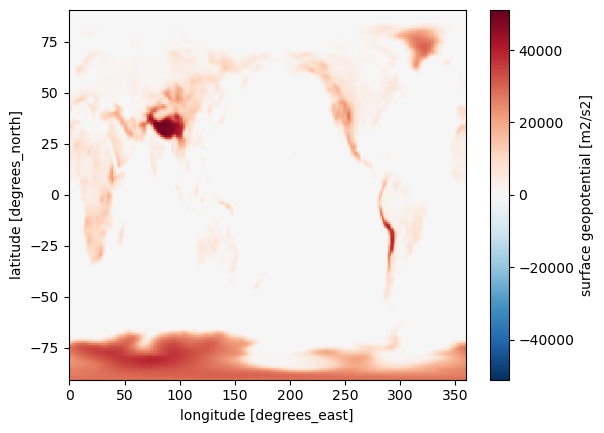

In [141]:
xr.open_dataset('/glade/campaign/cisl/aiml/wchapman/MLWPS/STAGING/f.e21.CREDIT_climate.statics_1.0deg_32levs_latlon_F32_hyai_fixed.nc')['PHIS'].plot()

In [ ]:
'

## Dry Mass

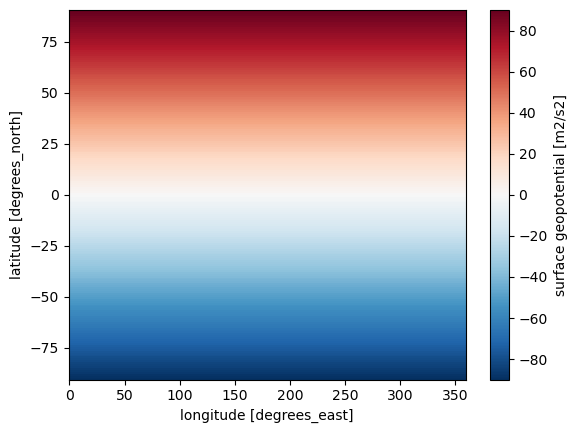

In [73]:
DSml['PHIS'].plot()

## RESTOM 

In [49]:
FNS = sorted(glob.glob('/glade/derecho/scratch/wchapman/CREDIT/cesm_wxformer_00191_nb/model_00223_b/1979-01-01T00Z/1D/averaged_SingleLevel_*'))
print('... opening model run ...')
DSs = xr.open_mfdataset(FNS)

... opening model run ...


In [51]:
FSNT_1m = DSs['FSNT'].resample(time='1MS').mean().load()
FLNT_1m = DSs['FLNT'].resample(time='1MS').mean().load()
model_level_file = '/glade/campaign/cisl/aiml/wchapman/MLWPS/STAGING/f.e21.CREDIT_climate.statics_1.0deg_32levs_latlon_F32_hyai.nc'
DSml = xr.open_dataset(model_level_file)
phsl = physics_hybrid_sigma_level(lat=torch.tensor(DSml['lat2d'].values), 
                           lon = torch.tensor(DSml['lat2d'].values),
                           coef_a = torch.tensor(DSml['hyai'].values),
                           coef_b = torch.tensor(DSml['hybi'].values),midpoint=True)

FSNT_ws = phsl.weighted_sum(torch.tensor((FSNT_1m/21600).isel(time=slice(0,359)).values), axis=(-2, -1))
FLNT_ws = phsl.weighted_sum(torch.tensor((FLNT_1m/-21600).isel(time=slice(0,359)).values), axis=(-2, -1))

In [52]:
conc = []
for yryr in range(1979,2015):
    print(f'doing {yryr}')
    DSdo_1 = xr.open_zarr(f'/glade/campaign/cisl/aiml/wchapman/MLWPS/STAGING/f.e21.CREDIT_climate_{yryr}_ERA5scaled_F32_Qtot.zarr')
    conc.append(DSdo_1)

print('... resampling and loading ....')
DSzarr1 = xr.concat(conc, dim='time')
DSzarr1_TP = DSzarr1[['FSNT','FLNT']].resample(time='1MS').mean().load()
print('... resampled and loaded ....')
FSNT_z_ws = phsl.weighted_sum(torch.tensor((DSzarr1_TP['FSNT']/21600).isel(time=slice(0,359)).values), axis=(-2, -1))
FLNT_z_ws = phsl.weighted_sum(torch.tensor((DSzarr1_TP['FLNT']/-21600).isel(time=slice(0,359)).values), axis=(-2, -1))

doing 1979
doing 1980
doing 1981
doing 1982
doing 1983
doing 1984
doing 1985
doing 1986
doing 1987
doing 1988
doing 1989
doing 1990
doing 1991
doing 1992
doing 1993
doing 1994
doing 1995
doing 1996
doing 1997
doing 1998
doing 1999
doing 2000
doing 2001
doing 2002
doing 2003
doing 2004
doing 2005
doing 2006
doing 2007
doing 2008
doing 2009
doing 2010
doing 2011
doing 2012
doing 2013
doing 2014
... resampling and loading ....
... resampled and loaded ....


## RESTOM

- add this as a validation meteric

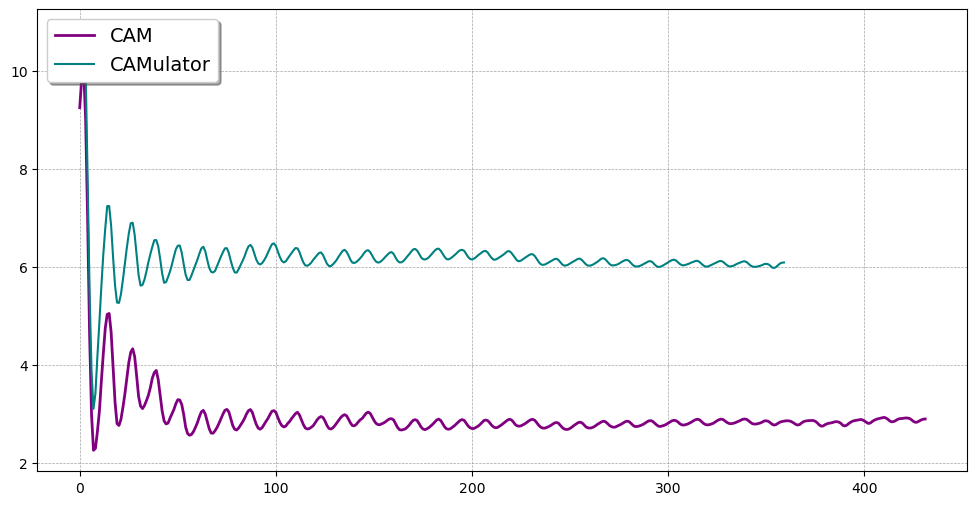

In [64]:
w = np.cos(np.radians(DSzarr1_TP['FSNT'].latitude))
FSNTts =(FSNT_1m/21600).weighted(w).mean(dim=("latitude","longitude"))
FLNTts =(FLNT_1m/-21600).weighted(w).mean(dim=("latitude","longitude"))

FSNTts_z = (DSzarr1_TP['FSNT']/21600).weighted(w).mean(dim=("latitude","longitude"))
FLNTts_z = (DSzarr1_TP['FLNT']/-21600).weighted(w).mean(dim=("latitude","longitude"))


plt.figure(figsize=(12, 6))  # Larger figure for better visibility

pcam = (FSNTts_z-FLNTts_z).rolling(time=350, min_periods=1).mean()
pulate = (FSNTts-FLNTts).rolling(time=350, min_periods=1).mean()

plt.plot(pcam, color='purple',linewidth=2, label='CAM')
plt.plot(pulate, color='teal', label='CAMulator')
# Add legend with improved styling
plt.legend(
    loc='upper left',
    fontsize=14,
    frameon=True,
    fancybox=True,
    shadow=True
)
# Add grid lines for better readability
plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)

plt.show()

In [ ]:
# Convert cftime to datetime
time_converted = [t.strftime('%Y-%m-%d') for t in DSzarr1_TP['time'].values]

In [ ]:
# Create the plot
plt.figure(figsize=(18, 6))  # Larger figure for better visibility

# Convert cftime to datetime
time_converted = [t.strftime('%Y-%m-%d') for t in DSzarr1_TP['time'].values]

# Extract indices for January 1 of each year
year_ticks = [i for i, t in enumerate(DSzarr1_TP['time'].values) if t.month == 1 and t.day == 1]

plt.plot(time_converted[:],smooth_1d_array(tottot,30)[:-1], label = 'CAM',color='purple', linewidth=2)
plt.plot(time_converted[:],smooth_1d_array(tottote,30)[:-1], label = 'CAMulator',color='teal', linewidth=2)
plt.legend()

# Customize x-axis ticks to show years
plt.xticks(
    year_ticks,
    [time_converted[i] for i in year_ticks],
    rotation=45,
    fontsize=11  # Smaller font size for clarity
)
# Adjust x-axis limits and labels
# plt.xlim([0, 5110])  # Limit the x-axis range
plt.xlabel("Time (Year)", fontsize=15)
plt.ylabel("TWP [kg/kg]", fontsize=15)
plt.xlim([0, 10900])  # Limit the x-axis range

# Add legend with improved styling
plt.legend(
    loc='upper left',
    fontsize=14,
    frameon=True,
    fancybox=True,
    shadow=True
)
# Add a title
plt.title("Comparison of Seasonal Cycle of Total Water Path: CAMulator vs. CAM", fontsize=14, fontweight='bold')

# Add grid lines for better readability
plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)

plt.show()